# SLS ER DIAGRAM

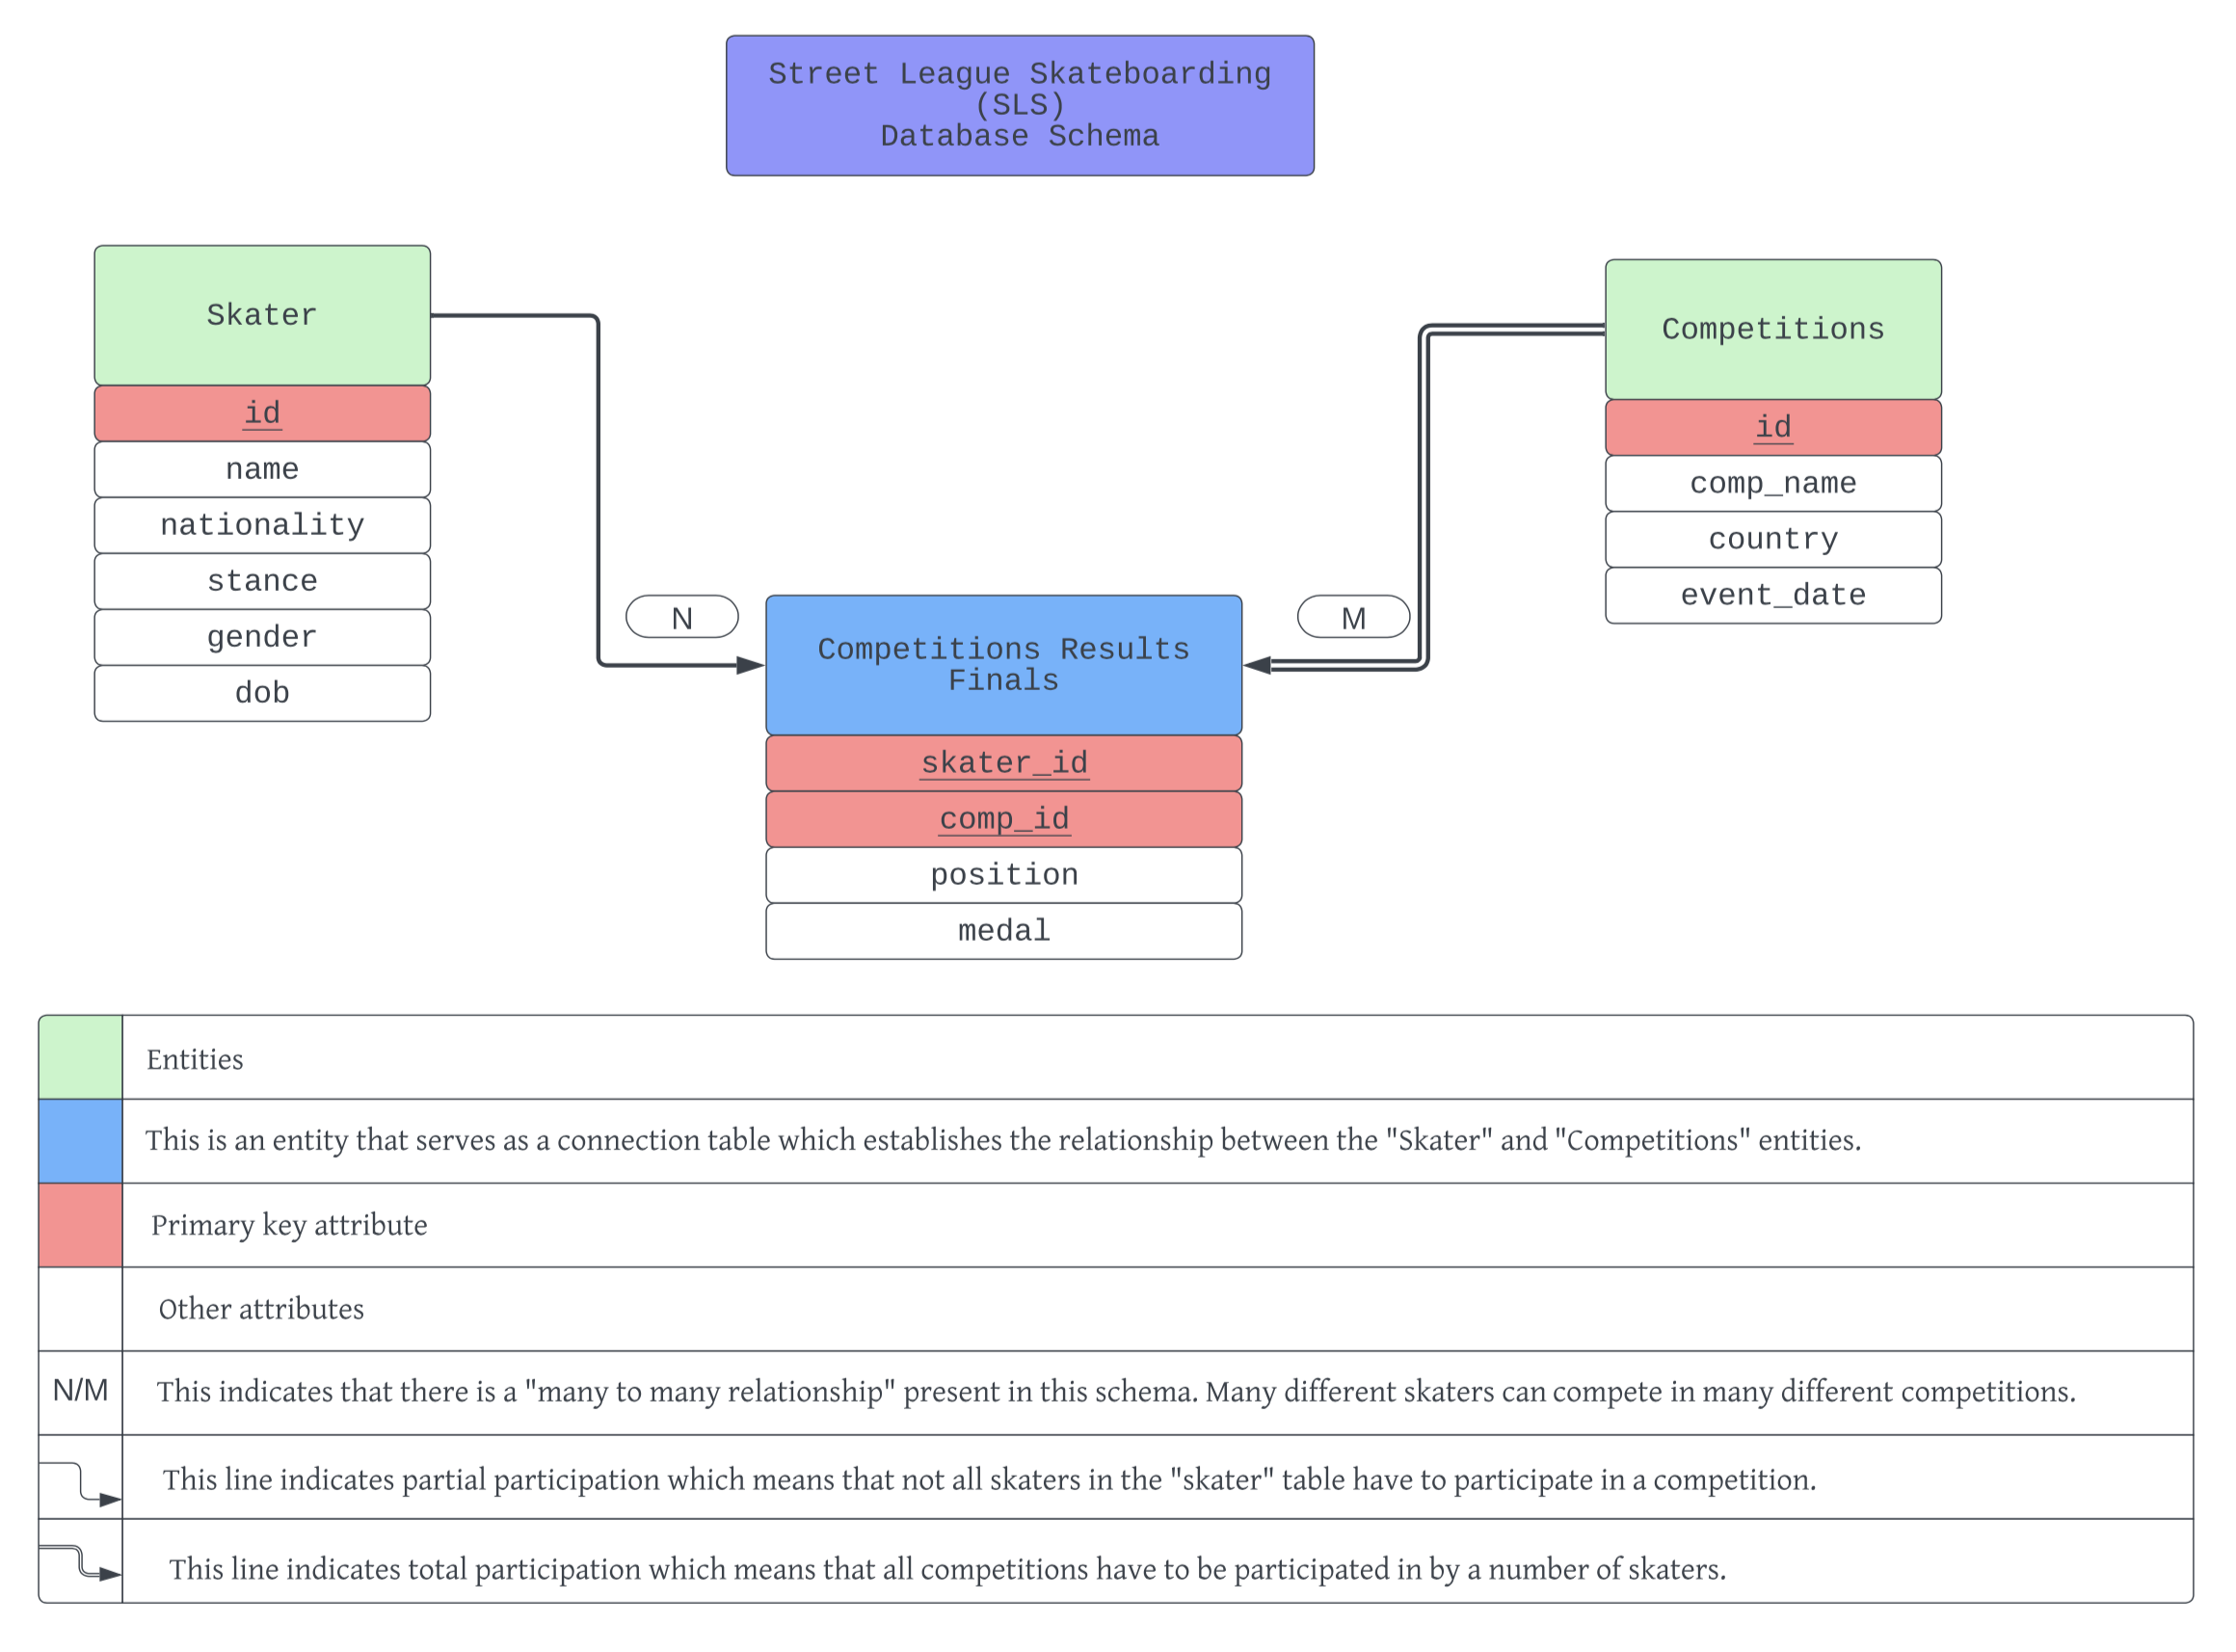

# CREATING THE SLS DATABASE AND TABLES IN PostgreSQL

In [ ]:
### CREATING THE TABLES ###

CREATE TABLE skaters(
    id     INTEGER PRIMARY KEY UNIQUE NOT NULL,
    name   TEXT UNIQUE NOT NULL,
    nationality TEXT,
	stance TEXT,
	gender TEXT,
	dob DATE
) ;

CREATE TABLE comps(
    id     INTEGER PRIMARY KEY UNIQUE NOT NULL,
    comp_name   TEXT NOT NULL,
    country TEXT,
	event_date DATE
) ;

CREATE TABLE comp_results_finals (
    skater_id     INTEGER,
    comp_id   INTEGER,
	position  INTEGER,
	medal TEXT,
    PRIMARY KEY (skater_id, comp_id)
) ;

### EXTRACTS OF INSERTING THE VALUES ###

INSERT INTO skaters VALUES
(1,'Ryan Sheckler','United States','Regular','M','1989-12-30'), etc...

INSERT INTO comps VALUES
(1001,'Las Vegas','United States','2010-09-25'), etc...

INSERT INTO comp_results_finals VALUES
(4,1001,1,'Gold'), etc...



# THE QUERIES

### Male and female SLS final participants distributed by country:

In [ ]:
SELECT nationality,gender,COUNT(*) AS Skaters
FROM skaters
GROUP BY nationality,gender
ORDER BY Skaters DESC,nationality DESC;


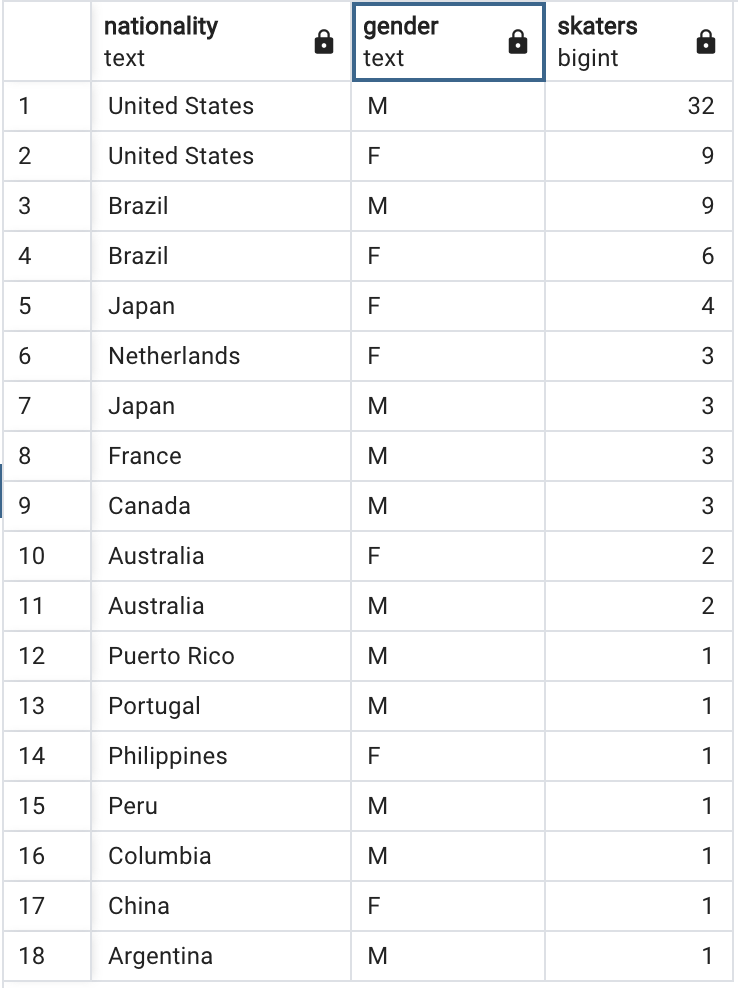

### How many male vs female skaters were represented in the combined SLS finals since 2010?:

In [ ]:
SELECT gender, COUNT(*)
FROM skaters
GROUP BY gender;


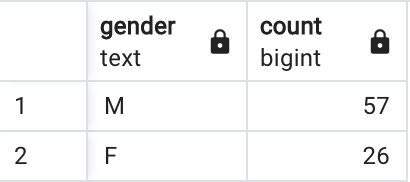

### What is the percentage ratio of male vs female skaters?: 

In [ ]:
WITH t (gender,skaters)
AS
(	SELECT gender, 
	COUNT(*) AS skaters
	FROM skaters
	GROUP BY gender
 )
SELECT gender, skaters,
	ROUND(skaters * 100.0/(SELECT SUM(skaters) FROM t)) AS percentage_of_skaters
FROM t;


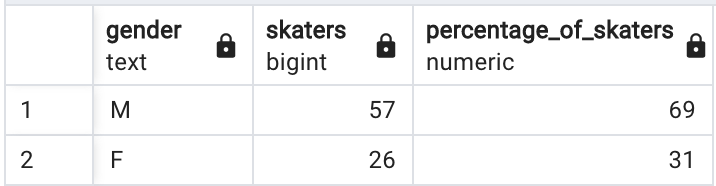

### Regular vs Goofy skater distribution:

In [ ]:
SELECT stance, COUNT(*)
FROM skaters
GROUP BY stance;


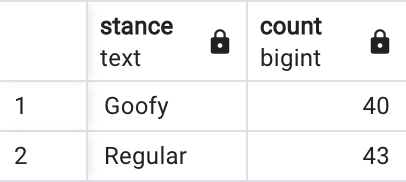

### What is the percentage ratio of regular vs goofy skaters?

In [ ]:
WITH t (stance,skaters)
AS
(	SELECT stance, 
	COUNT(*) AS skaters
	FROM skaters
	GROUP BY stance
 )
SELECT stance, skaters,
	ROUND(skaters * 100.0/(SELECT SUM(skaters) FROM t)) AS percentage_of_skaters
FROM t;


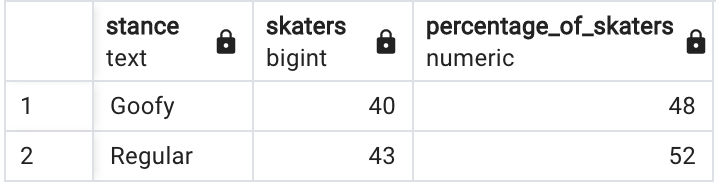

### FIXING SPELLING MISTAKE IN TABLE:
###### While doing some data exploration I found that there was a spelling mistake in the medal column that had to be fixed before executing the related queries.

In [ ]:
UPDATE comp_results_finals
SET medal = 'Silver'
WHERE medal = 'Sliver';


# JOINING THE TABLES

In [ ]:
SELECT s.name, c.comp_name, crf."position", crf.medal
FROM skaters AS s
INNER JOIN comp_results_finals AS crf
	ON crf.skater_id = s.id
INNER JOIN comps AS c
	ON crf.comp_id = c.id
;

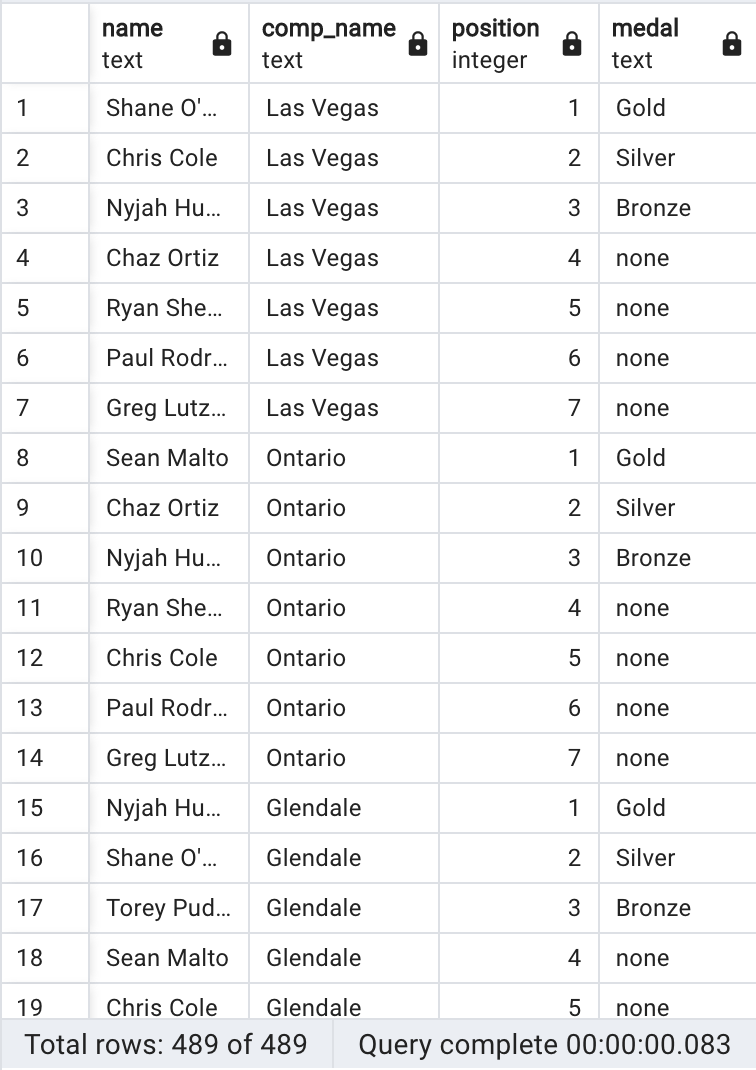

### Who is the skater with the highest medal value per year per gender?
###### I started off with who won the most medals per year but this led to a problem where the skaters won the same amount of medals but the medals differed in value when it came to Gold, Silver and Bronze. I then had to create a query where I had to assign values to the medals in order to calculate the value rather than the total medals won.

### MALES

In [ ]:
WITH t(name, gender, event_date, medal)
AS
(	SELECT s.name, s.gender, c.event_date, crf.medal
	FROM skaters AS s
	INNER JOIN comp_results_finals AS crf
		ON crf.skater_id = s.id
	INNER JOIN comps AS c
		ON crf.comp_id = c.id
	WHERE crf.medal = 'Gold' OR crf.medal = 'Silver' OR crf.medal = 'Bronze'
)
, t1 AS
(	SELECT  EXTRACT(YEAR FROM event_date) AS year, name,gender, medal, 
		CASE medal WHEN 'Gold' THEN 3 WHEN 'Silver' THEN 2 WHEN 'Bronze' THEN 1 END AS medal_value
		FROM t
		WHERE gender = 'M'
		ORDER BY year
)
, t2 AS
(	SELECT year, name,medal,COUNT(medal) AS medal_count, 
             SUM(medal_value) OVER(PARTITION BY medal,name,year) AS medal_value 
	FROM t1
	GROUP BY year,name,medal,medal_value
	ORDER BY year
) 
, t3 AS
(	SELECT year, name, medal, medal_count, medal_value, (medal_count * medal_value) AS value
	FROM t2
)
, t4 AS
(
	SELECT year, name, SUM(value) AS medal_value, 
            ROW_NUMBER() OVER(PARTITION BY year ORDER BY SUM(value) DESC) AS row_number
	FROM t3
	GROUP BY year, name
	ORDER BY year, medal_value DESC
)
SELECT year,name,medal_value
FROM t4
WHERE row_number = 1
;


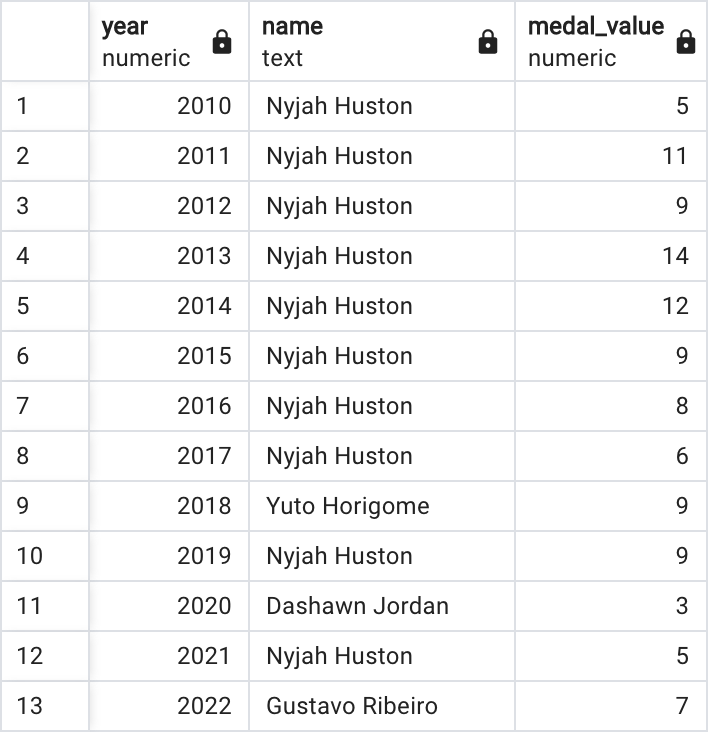

### FEMALES

In [ ]:
WITH t(name, gender, event_date, medal)
AS
(	SELECT s.name, s.gender, c.event_date, crf.medal
	FROM skaters AS s
	INNER JOIN comp_results_finals AS crf
		ON crf.skater_id = s.id
	INNER JOIN comps AS c
		ON crf.comp_id = c.id
	WHERE crf.medal = 'Gold' OR crf.medal = 'Silver' OR crf.medal = 'Bronze'
)
, t1 AS
(	SELECT  EXTRACT(YEAR FROM event_date) AS year, name,gender, medal, 
		CASE medal WHEN 'Gold' THEN 3 WHEN 'Silver' THEN 2 WHEN 'Bronze' THEN 1 END AS medal_value
		FROM t
		WHERE gender = 'F'
		ORDER BY year
)
, t2 AS
(	SELECT year, name,medal,COUNT(medal) AS medal_count, 
             SUM(medal_value) OVER(PARTITION BY medal,name,year) AS medal_value 
	FROM t1
	GROUP BY year,name,medal,medal_value
	ORDER BY year
) 
, t3 AS
(	SELECT year, name, medal, medal_count, medal_value, (medal_count * medal_value) AS value
	FROM t2
)
, t4 AS
(
	SELECT year, name, SUM(value) AS medal_value, 
            ROW_NUMBER() OVER(PARTITION BY year ORDER BY SUM(value) DESC) AS row_number
	FROM t3
	GROUP BY year, name
	ORDER BY year, medal_value DESC
)
SELECT year,name,medal_value
FROM t4
WHERE row_number = 1
;


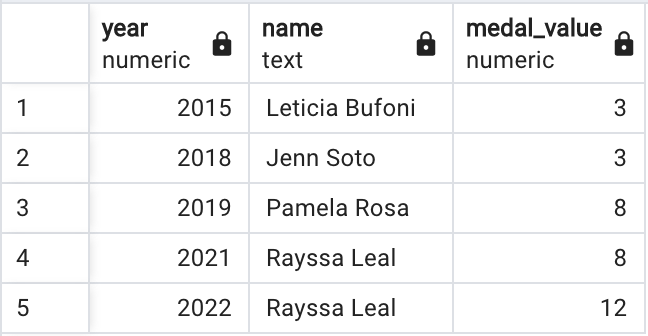

### Who was the youngest and oldest skater ever to participate in an SLS Final?

#### YOUNGEST

In [ ]:
WITH t(name,dob,event_date)
AS
(
	SELECT s.name, s.dob, c.event_date
		FROM skaters AS s
		INNER JOIN comp_results_finals AS crf
			ON crf.skater_id = s.id
		INNER JOIN comps AS c
			ON crf.comp_id = c.id	
)	
SELECT name, EXTRACT(YEAR FROM(AGE(event_date,dob))) AS age
FROM t
ORDER BY age
LIMIT 1
;


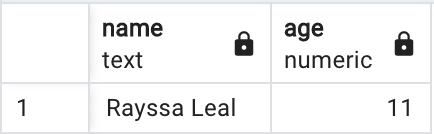

#### OLDEST

In [ ]:
WITH t(name,dob,event_date)
AS
(
	SELECT s.name, s.dob, c.event_date
		FROM skaters AS s
		INNER JOIN comp_results_finals AS crf
			ON crf.skater_id = s.id
		INNER JOIN comps AS c
			ON crf.comp_id = c.id	
)	
SELECT name, EXTRACT(YEAR FROM(AGE(event_date,dob))) AS age
FROM t
ORDER BY age DESC
LIMIT 1;


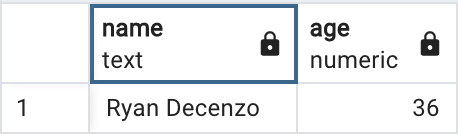

### Youngest skater to ever win a gold medal?

In [ ]:
WITH t(name,dob,event_date,medal)
AS
(
	SELECT s.name, s.dob, c.event_date, crf.medal
		FROM skaters AS s
		INNER JOIN comp_results_finals AS crf
			ON crf.skater_id = s.id
		INNER JOIN comps AS c
			ON crf.comp_id = c.id	
		WHERE crf.medal = 'Gold' OR crf.medal = 'Silver' OR crf.medal = 'Bronze'	
)	
SELECT name, EXTRACT(YEAR FROM(AGE(event_date,dob))) AS age, medal
FROM t
WHERE medal = 'Gold'
ORDER BY age 
LIMIT 1
;


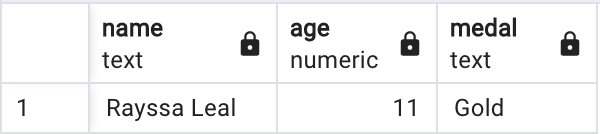

### Oldest skater to ever win a gold medal?

In [ ]:
WITH t(name,dob,event_date,medal)
AS
(
	SELECT s.name, s.dob, c.event_date, crf.medal
		FROM skaters AS s
		INNER JOIN comp_results_finals AS crf
			ON crf.skater_id = s.id
		INNER JOIN comps AS c
			ON crf.comp_id = c.id	
		WHERE crf.medal = 'Gold' OR crf.medal = 'Silver' OR crf.medal = 'Bronze'	
)	
SELECT name, EXTRACT(YEAR FROM(AGE(event_date,dob))) AS age, medal
FROM t
WHERE medal = 'Gold'
ORDER BY age DESC
LIMIT 1
;


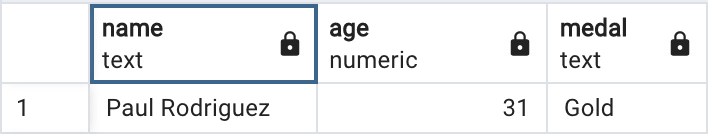

## Calculate the average age for male and female groups over the SLS period and compare.

In [ ]:
WITH t(name,gender,dob,event_date)
AS
(
	SELECT s.name,s.gender, s.dob, c.event_date
		FROM skaters AS s
		INNER JOIN comp_results_finals AS crf
			ON crf.skater_id = s.id
		INNER JOIN comps AS c
			ON crf.comp_id = c.id	
			
) 
,t1 AS	
(
	SELECT  name, gender, AVG(EXTRACT(YEAR FROM(AGE(event_date,dob)))) AS age
	FROM t
	GROUP BY name,gender
	ORDER BY age
)
SELECT gender, ROUND(AVG(age),2) AS ave_age_per_gender
FROM t1
GROUP BY gender
;


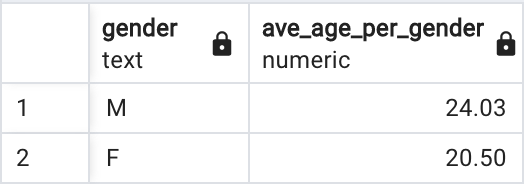

## Calculate the conversion rate of a skater for how many times he/she has reached a final vs how many times they have reached the top 3.

### MALES

In [ ]:
WITH t(name,gender,medal)
AS
(	SELECT s.name,s.gender, crf.medal
	FROM skaters AS s
	INNER JOIN comp_results_finals AS crf
		ON crf.skater_id = s.id
	INNER JOIN comps AS c
		ON crf.comp_id = c.id
)
, t1 AS
(	SELECT name,gender, medal, CASE medal 
		WHEN 'Gold' THEN 1 
		WHEN 'Silver' THEN 1 
		WHEN 'Bronze' THEN 1 
		WHEN 'none' THEN 0 
		END AS medal_value
	FROM t
 	WHERE gender = 'M'
)
, t2 AS
(	SELECT name, COUNT(name) AS in_finals, SUM(medal_value) AS in_top_3
	FROM t1
	GROUP BY name
)
SELECT name, in_finals, in_top_3, ROUND((in_top_3*100.00/in_finals),2) AS conversion_rate
FROM t2
ORDER BY in_finals DESC,conversion_rate DESC
;


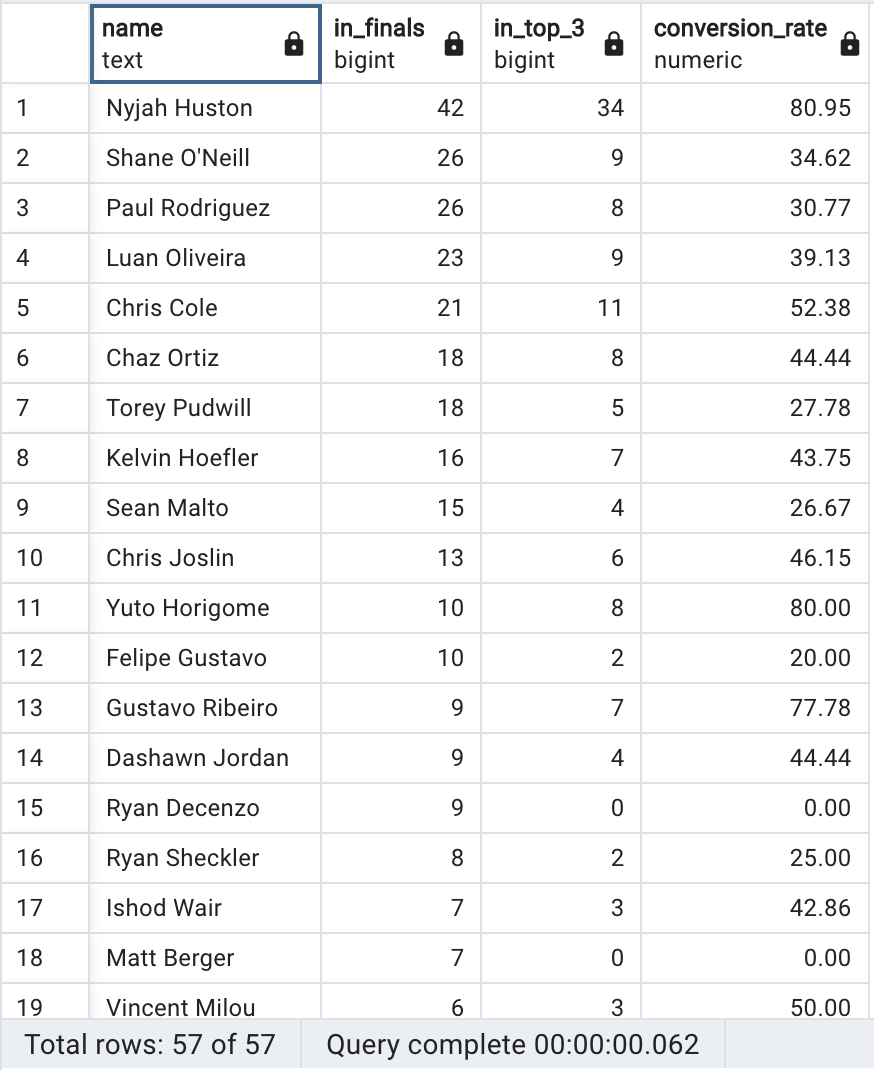

### FEMALES

In [ ]:
WITH t(name,gender,medal)
AS
(	SELECT s.name,s.gender, crf.medal
	FROM skaters AS s
	INNER JOIN comp_results_finals AS crf
		ON crf.skater_id = s.id
	INNER JOIN comps AS c
		ON crf.comp_id = c.id
)
, t1 AS
(	SELECT name,gender, medal, CASE medal 
		WHEN 'Gold' THEN 1 
		WHEN 'Silver' THEN 1 
		WHEN 'Bronze' THEN 1 
		WHEN 'none' THEN 0 
		END AS medal_value
	FROM t
 	WHERE gender = 'F'
)
, t2 AS
(	SELECT name, COUNT(name) AS in_finals, SUM(medal_value) AS in_top_3
	FROM t1
	GROUP BY name
)
SELECT name, in_finals, in_top_3, ROUND((in_top_3*100.00/in_finals),2) AS conversion_rate
FROM t2
ORDER BY in_finals DESC,conversion_rate DESC
;


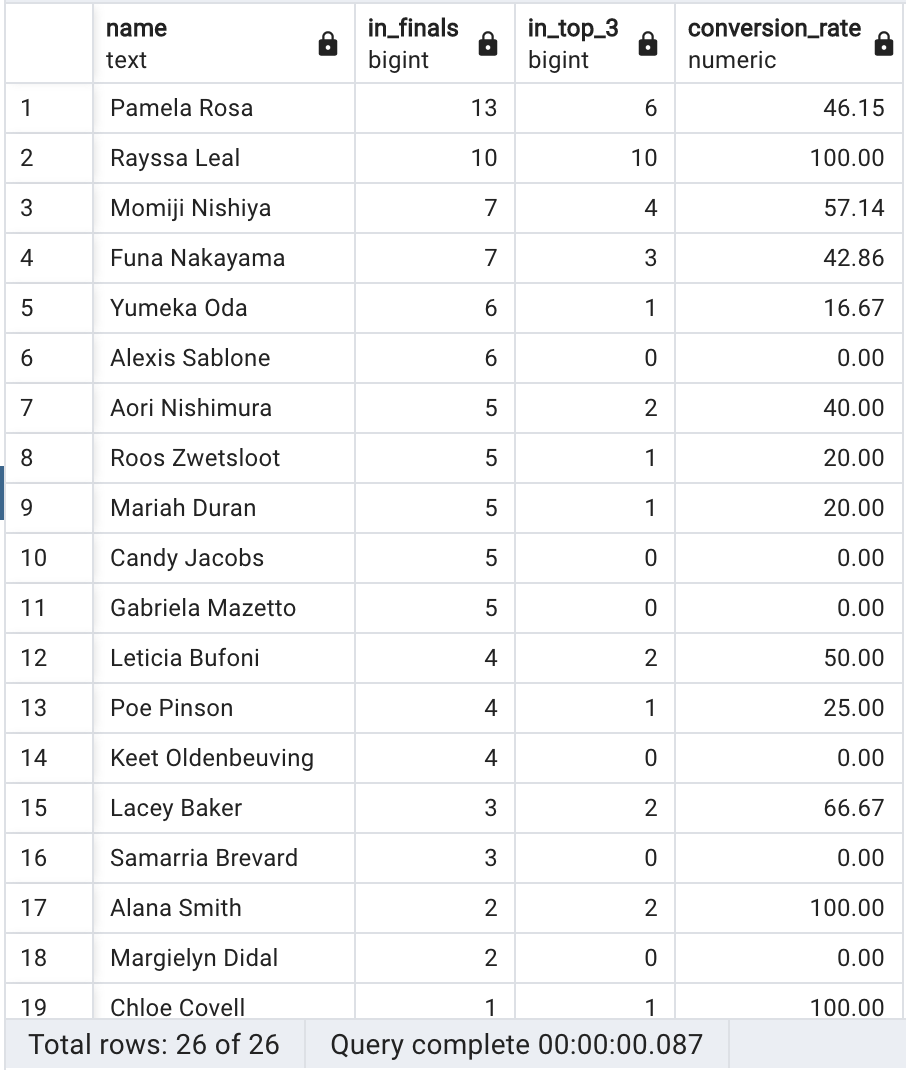